### Imports

In [1]:
from torch import nn
from torch import optim
from torch.functional import F
from torchvision import transforms
from torchsummary import summary
from torch.utils.data import RandomSampler
from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import random
import torch
import torchvision

### Constants and definitions

In [2]:
%matplotlib inline

BATCH_SIZE = 128
COMPRESSED_DIMS = 2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 15
LEARNING_RATE = 1e-3

### Load dataset

In [3]:
MNIST_train = torchvision.datasets.MNIST('../data/', 
                                         train = True, 
                                         download = True, 
                                         transform = transforms.Compose([transforms.ToTensor(),
                                                                         transforms.Normalize((0.1307,), (0.3081,))]))

MNIST_test = torchvision.datasets.MNIST('../data/', 
                                        train = False, 
                                        download = True,
                                        transform=transforms.Compose([transforms.ToTensor(),
                                                                      transforms.Normalize((0.1307,), (0.3081,))]))

In [4]:
MNIST_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../data/
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [5]:
MNIST_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

### Create data loaders

In [6]:
train_loader = torch.utils.data.DataLoader(MNIST_train, batch_size = BATCH_SIZE, shuffle = True)

In [7]:
test_loader = torch.utils.data.DataLoader(MNIST_test, batch_size = 2 * BATCH_SIZE, shuffle = False)

### Encoder network

In [8]:
class MNIST_Encoder(nn.Module):
    def __init__(self):
        super(MNIST_Encoder, self).__init__()
        self.encode = nn.Sequential(
                        nn.Conv2d(1, 32, 3, 1),
                        nn.LeakyReLU(),
                        nn.Conv2d(32, 64, 3, 2),
                        nn.LeakyReLU(),
                        nn.Conv2d(64, 64, 3, 2),
                        nn.LeakyReLU(),
                        nn.Conv2d(64, 64, 3, 1),
                        nn.Flatten(),
                        nn.Linear(576, COMPRESSED_DIMS))

    def forward(self, x):
        return self.encode(x)

### Decoder network

In [9]:
class MNIST_Decoder(nn.Module):
    def __init__(self):
        super(MNIST_Decoder, self).__init__()
        self.lin = nn.Linear(COMPRESSED_DIMS, 3136)
        self.decode = nn.Sequential(
                        nn.ConvTranspose2d(64, 64, 3, padding=1),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(32, 1, 3, padding=1),
                        nn.Sigmoid())
        
    def forward(self, x):
        x = self.lin(x)
        x = x.view(-1, 64, 7, 7)
        x = self.decode(x)
        
        return x

### Autoencoder

In [10]:
class MNIST_Autoencoder(nn.Module):
    def __init__(self):
        super(MNIST_Autoencoder, self).__init__()
        self.encode = MNIST_Encoder()
        self.decode = MNIST_Decoder()
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        
        return x

### Training loop

Create model:

In [11]:
autoencoder = MNIST_Autoencoder()
autoencoder = autoencoder.to(DEVICE)

In [12]:
summary(autoencoder, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
         LeakyReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 12, 12]          18,496
         LeakyReLU-4           [-1, 64, 12, 12]               0
            Conv2d-5             [-1, 64, 5, 5]          36,928
         LeakyReLU-6             [-1, 64, 5, 5]               0
            Conv2d-7             [-1, 64, 3, 3]          36,928
           Flatten-8                  [-1, 576]               0
            Linear-9                    [-1, 2]           1,154
    MNIST_Encoder-10                    [-1, 2]               0
           Linear-11                 [-1, 3136]           9,408
  ConvTranspose2d-12             [-1, 64, 7, 7]          36,928
        LeakyReLU-13             [-1, 64, 7, 7]               0
  ConvTranspose2d-14           [-1, 64,

Define optimizer:

In [13]:
optimizer = optim.Adam(autoencoder.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

Training loop:

In [14]:
def fit(epochs, model, loss, optimizer, data):
    
    # initialize info dict
    info = {
        'epoch': [],
        'loss': []
    }
        
    # for each epoch
    for epoch in range(epochs):
    
        # set the model to training mode
        model.train()
        
        # iterate through the dataset
        for x, _ in tqdm(data):
            
            # send data to GPU
            x = x.to(DEVICE)
            
            # infer and compute loss
            y_hat = model(x)
            loss_value = loss(y_hat, x)
            
            # update weights
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()
                        
        # set model in inference mode
        model.eval()
        
        # without computing gradients
        with torch.no_grad():
            
            # compute validation loss
            validation_loss = 0
            for batch, _ in test_loader:
                x_val = batch.clone()
                x_val = x_val.to(DEVICE)
                y_val = model(batch.to(DEVICE))
                validation_loss += loss(y_val, x_val)            
        
        # update info
        validation_loss = validation_loss.item() / len(MNIST_train)
        info['epoch'].append(epoch + 1)
        info['loss'].append(validation_loss)
        
        # log
        print(f'End of epoch: {epoch + 1}\nValidation loss: {validation_loss}\n\n')
            
    # return training info
    return info

In [15]:
info = fit(EPOCHS, autoencoder, nn.MSELoss(), optimizer, train_loader)


End of epoch: 1
Validation loss: 0.00047126305898030597





End of epoch: 2
Validation loss: 0.0004514148394266764





End of epoch: 3
Validation loss: 0.00044476839701334636





End of epoch: 4
Validation loss: 0.0004410336176554362





End of epoch: 5
Validation loss: 0.0004387505849202474





End of epoch: 6
Validation loss: 0.00043721510569254556





End of epoch: 7
Validation loss: 0.00043570547103881835





End of epoch: 8
Validation loss: 0.00043436482747395835





End of epoch: 9
Validation loss: 0.00043393980662027995





End of epoch: 10
Validation loss: 0.00043297894795735675





End of epoch: 11
Validation loss: 0.0004318502426147461





End of epoch: 12
Validation loss: 0.00043170318603515627





End of epoch: 13
Validation loss: 0.0004310353914896647





End of epoch: 14
Validation loss: 0.00043196980158487957





End of epoch: 15
Validation loss: 0.0004317289034525553




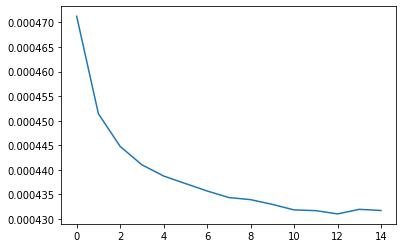

In [16]:
plt.plot(list(range(len(info['loss']))), info['loss'])

### Results

Reconstructing input images:

In [17]:
autoencoder.to('cpu')
autoencoder = autoencoder.eval()

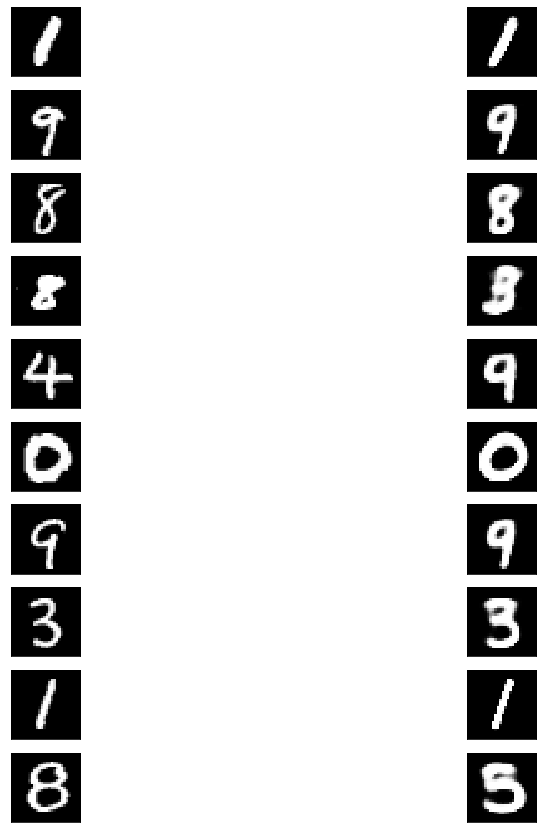

In [18]:
originals = []
generated = []

for _ in range(10):
    sample = random.randint(0, len(MNIST_test))
    original = MNIST_test[sample][0]
    x = original.unsqueeze(0)

    with torch.no_grad():
        y = autoencoder(x)

    originals.append(original.squeeze())
    generated.append(y.squeeze())

f, axes = plt.subplots(10, 
                       2,
                       figsize=(15,15),
                       sharex=True, 
                       sharey=True,
                       subplot_kw=dict(aspect='equal'))

for i in range(10):
    axes[i][0].imshow(originals[i], cmap='gray')
    axes[i][0].set_xticks([])
    axes[i][0].set_yticks([])
    axes[i][1].imshow(generated[i], cmap='gray')
    axes[i][1].set_xticks([])
    axes[i][1].set_yticks([])

Plot distribution:

In [19]:
# get encoder part of the autoencoder
encoder = autoencoder.encode
encoder.eval();

In [20]:
# get random batch from test set
test_images, test_labels = next(iter(test_loader))

# setup empty encodings
encodings = {i : [] for i in range(10)}

# without computing gradients
with torch.no_grad():
    
    # for each digit in the dataset
    for digit in range(10):
        
        # encode and store samples
        images = test_images[test_labels == digit]
        encoded = encoder(images)
        encodings[digit] = [value.numpy() for value in encoded]

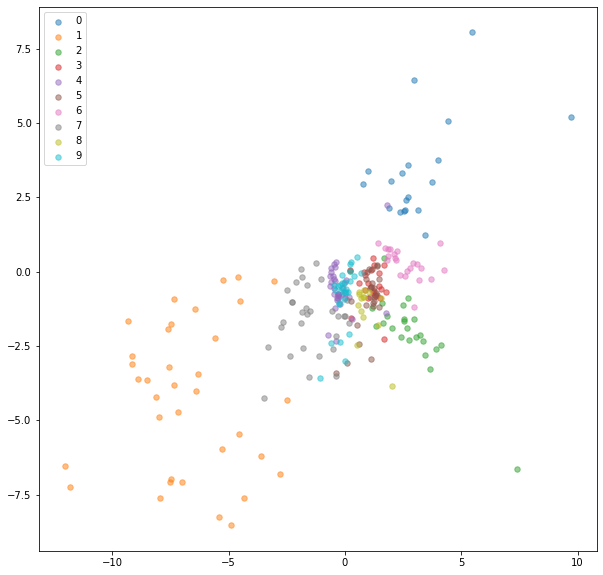

In [21]:
# plot distribution
fig = plt.figure(figsize=(10, 10))
axis = fig.add_subplot(1, 1, 1)
for digit in encodings.keys():
    xs = [x[0] for x in encodings[digit]]
    ys = [x[1] for x in encodings[digit]]
    axis.scatter(xs, ys, alpha=0.5, s=30, label=str(digit))
        
plt.legend(loc=2)
plt.show()

Generate digits:

In [22]:
# get decoder part of the autoencoder
decoder = autoencoder.decode
decoder = decoder.to('cpu')
decoder.eval();

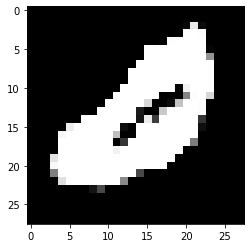

In [23]:
# enter your encoded representation here
encoded = torch.tensor([[21., 0.]])

# without computing gradients
with torch.no_grad():
    
    # reconstruct image from representation
    x = decoder(encoded)
    
# display generated image
plt.imshow(x.view(28, 28).numpy(), cmap='gray')